In [1]:
import os
os.chdir(os.path.join(os.getcwd(), '..'))

In [2]:
import torch
from tqdm import tqdm
import yaml
from models.bendr import EncoderConv, ContextNetwork

with open('configs/od_config_bendr.yaml', 'r') as file:
        cfg = yaml.safe_load(file)


encoder_sd = torch.load('/Users/ksc/Desktop/Нейротемка/checkpoints_70ep/encoder_2024-12-23T19:57:53.101820.pt', map_location=torch.device('cpu') )
context_network_sd = torch.load('/Users/ksc/Desktop/Нейротемка/checkpoints_70ep/context_network_2024-12-23T19:57:53.101820.pt', map_location=torch.device('cpu') )


encoder = EncoderConv(**cfg['encoder'])
context_network = ContextNetwork(**cfg['context_network'])

encoder.load_state_dict(encoder_sd)
context_network.load_state_dict(context_network_sd)
encoder.eval()
context_network.eval()

/var/folders/z2/jk8j2nn905v4_76cbzdgkrxm0000gn/T/ipykernel_23748/711149925.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_sd = torch.load('/Users/ksc/Desktop/Н

ContextNetwork(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-19): 20 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (target_proj): Linear(in_features=512, out_features=512, bias=True)
  (positional_emb): SinusoidalPositionalEncoding(
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=False)
  )
)

In [3]:
from dataset.labeled_dataset import EEGLabeledDataset
from torch.utils.data import DataLoader


dataset = EEGLabeledDataset(
    data_path='/Users/ksc/Desktop/Нейротемка/music_data/h5',
    cache_processed_path='/Users/ksc/Desktop/Нейротемка/music_data/cache',
    train_length=73728,
    dataset_mode='sequential',
    target_config={
        'user_id': True,
        'activity': True
    },
    clipped_threshold=100
)

loader = DataLoader(dataset, 2, shuffle=False, drop_last=False)
next(iter(loader))['data'].shape


Building cache...


One chunk from each file:  29%|██▊       | 2/7 [00:00<00:01,  4.85it/s]

Skipping last 25752
Skipping last 67992


One chunk from each file:  43%|████▎     | 3/7 [00:00<00:00,  4.81it/s]

Skipping last 42936


One chunk from each file:  57%|█████▋    | 4/7 [00:00<00:00,  3.91it/s]

Skipping last 61976


One chunk from each file:  71%|███████▏  | 5/7 [00:01<00:00,  4.14it/s]

Skipping last 25784


One chunk from each file: 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]

Skipping last 25176
Skipping last 12760


torch.Size([2, 4, 73728])

In [4]:
context = []
uid = []
song_id = []
is_liked = []

encoder_fs = [[] for _ in range(6)]
trans_fs = [[] for _ in range(20)]

with torch.no_grad():
    for batch in tqdm(loader):        
        x = batch['data']

        for i in range(6):
            x = encoder.stack[i](x)
            encoder_fs[i].append(x.mean(2).cpu())
        x = x.permute(0, 2, 1)
        x = context_network.positional_emb(x)
        
        for i in range(20):
            x = context_network.transformer_encoder.layers[i](x)
            trans_fs[i].append(x)
        
        uid.append(batch['user_id'])
        song_id.append(batch['song_ids'])
        is_liked.append(batch['is_liked'])

# with torch.no_grad():
#     for batch in tqdm(loader):
#         batch = encoder(batch)
#         batch = context_network(batch, run_full=True)
#         context.append(batch['full_context_vectors'])
        

uid = torch.cat(uid, 0)
song_id = torch.cat(song_id, 0)
is_liked = torch.cat(is_liked, 0)
unique_id = song_id * 1000 + uid.unsqueeze(1)
trans_fs = [torch.cat(x, 0) for x in trans_fs]
encoder_fs = [torch.cat(x, 0) for x in encoder_fs]

100%|██████████| 24/24 [00:21<00:00,  1.10it/s]


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

msk_is_test = (torch.tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1]) == 1)

for i in range(20):
    context = trans_fs[i]
    X_train = context[~msk_is_test, : ,:].flatten(0, 1)
    y_train = is_liked[~msk_is_test, :].flatten()
    train_nz = y_train != 0
    X_train, y_train = X_train[train_nz], y_train[train_nz]


    X_test = context[msk_is_test, : ,:].flatten(0, 1)
    y_test = is_liked[msk_is_test, :].flatten()
    unique_id_test = unique_id[msk_is_test, :].flatten()
    test_nz = y_test != 0
    X_test, y_test, unique_id_test = X_test[test_nz], y_test[test_nz], unique_id_test[test_nz]
    # print(X_train.shape, X_test.shape)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = LogisticRegression(penalty='l2', C=0.0001, max_iter=300) # penalty='l1', solver='liblinear')#, C=0.001) # LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train)
    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)
    print(f"{i}======")
    print(f"Train acc: {((preds_train == y_train) * 1.0).mean().item() * 100:.2f}%") 
    print(f"Test  acc: {((preds_test == y_test) * 1.0).mean().item() * 100:.2f}%")

0======
Train acc: 65.85%
Test  acc: 66.51%
1======
Train acc: 66.67%
Test  acc: 66.39%
2======
Train acc: 67.07%
Test  acc: 66.42%
3======
Train acc: 67.23%
Test  acc: 66.53%
4======
Train acc: 68.11%
Test  acc: 66.85%
5======
Train acc: 69.14%
Test  acc: 67.30%
6======
Train acc: 69.26%
Test  acc: 67.64%
7======
Train acc: 69.47%
Test  acc: 67.95%
8======
Train acc: 69.62%
Test  acc: 68.30%
9======
Train acc: 69.60%
Test  acc: 68.12%
10======
Train acc: 69.76%
Test  acc: 67.05%
11======
Train acc: 69.06%
Test  acc: 66.90%
12======
Train acc: 68.67%
Test  acc: 66.89%
13======
Train acc: 68.83%
Test  acc: 66.94%
14======
Train acc: 68.70%
Test  acc: 66.87%
15======
Train acc: 68.44%
Test  acc: 66.77%
16======
Train acc: 68.48%
Test  acc: 66.80%
17======
Train acc: 68.39%
Test  acc: 66.87%
18======
Train acc: 68.44%
Test  acc: 66.94%
19======
Train acc: 68.40%
Test  acc: 66.41%


In [6]:
((model.coef_ != 0.0) * 1.0).sum()

512.0

In [7]:
1 - (y_test - 1.0).mean()

tensor(0.6763)

In [8]:
q = []
all_labels = []

for el in unique_id_test.unique():
    msk = unique_id_test == el 
    assert y_test[msk].min() == y_test[msk].max()
    lbl = y_test[msk][0]
    
    q.append(((preds_test[msk] == lbl) * 1.0).mean())
    all_labels.append(lbl)
    # print(((preds_test[msk] == lbl) * 1.0).mean())
    
print("With voting:", ((torch.tensor(q) > 0.5) * 1.0).mean())
print(f"Average: {1 - ((torch.tensor(all_labels) - 1) * 1.0).mean()}")
plt.hist(q, bins=50)
None

With voting: tensor(0.6343)
Average: 0.6791044473648071


NameError: name 'plt' is not defined

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


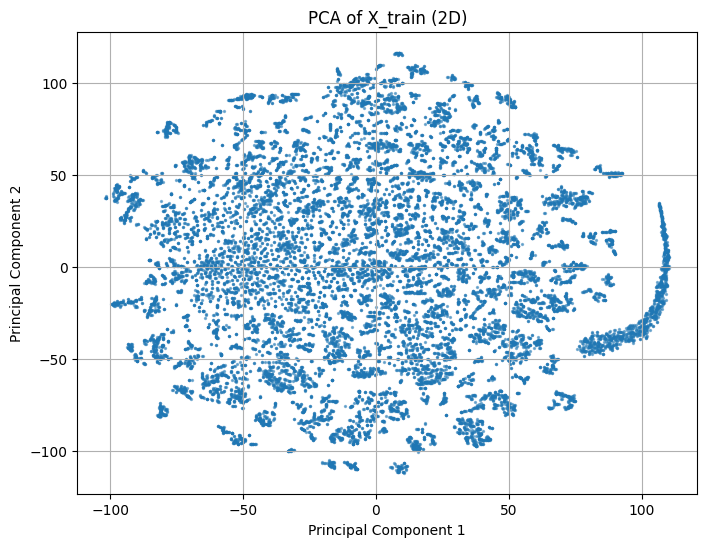

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform PCA
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_train_tsne = tsne.fit_transform(X_train.numpy())

# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], s=2, alpha=0.5)
plt.title("PCA of X_train (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

In [ ]:
len(unique_id_test.unique())

134

In [ ]:
q

[tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(1.),

In [ ]:
((torch.tensor(q) > 0.5) * 1.0).mean()

tensor(0.6716)

In [ ]:
((y_train == 0) * 1.0).mean()

tensor(0.)

In [ ]:
msk_is_test.shape

torch.Size([47])